### **IMPORTING LIBRARIES**

In [1]:
#importing libraries
from google.colab import drive
drive.mount('/content/drive')
from sklearn import metrics
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from __future__ import print_function,division
from torch.optim import lr_scheduler
from pylab import *
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
cudnn.benchmark=True
plt.ion()
!pip install split-folders
import splitfolders 
#setting device to GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **DATA PREPROCESSING**

In [2]:
#data transformation(includes resizing,center cropping,data normalizing with Imagenet dataset mean and std)
data_transforms={'train':transforms.Compose([transforms.RandomResizedCrop(224)
,transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
'val':transforms.Compose([transforms.Resize(256)
,transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
'test':transforms.Compose([transforms.Resize(256)
,transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
}

### **SPLITTING TRAINING DATA INTO TRAIN AND VALIDATION DATA(80/20 split)**

In [3]:
input_folder = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/train'
output_folder = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/train_split'
splitfolders.ratio(input_folder, output = output_folder, seed = 1337, ratio = (0.8, 0.2), group_prefix=None, move = False )

Copying files: 532 files [01:59,  4.45 files/s]


### **LOADING TRAINING DATA USING DATA LOADER** 

In [4]:
data_dir_full = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/'
#loading data
data_dir = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/train_split'

image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}

image_datasets['test']=datasets.ImageFolder(os.path.join(data_dir_full,'test'),data_transforms['test'])
#loading data into data_loader in batches
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True,num_workers=4) for x in ['train','val','test']}

dataset_sizes={x: len(image_datasets[x]) for x in ['train','val','test']}

class_names=image_datasets['train'].classes

print(dataset_sizes['train']) #423 train  size
print(dataset_sizes['val']) #109 validation size
print(dataset_sizes['test'])    #120 test size

print(class_names)

423
109
120
['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']


### **LOADING TEST DATA**

In [5]:
data_dir_1 = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir_1,x),data_transforms[x]) for x in ['test']}
dataloaders_test={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=120,shuffle=False,num_workers=4) for x in ['test']}

### **LOADING RESNET18**

In [6]:
model_ft=models.resnet18(pretrained=True) #loading into model_ft
for param in model_ft.parameters():
  param.requires_grad = False                  #freezing the gradients
num_ftrs=model_ft.fc.in_features  #features of last fully connected layer

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### **ADDING LAST FC LAYER**

In [7]:
#adding last linear layer with 6 output classes 
model_ft.fc = nn.Linear(num_ftrs, 6)
model_ft=model_ft.to(device)  #transferring model to cuda(GPU)  
criterion=nn.CrossEntropyLoss()    #using cross entropy loss
optimizer_ft=optim.SGD(model_ft.fc.parameters(),lr=0.001,momentum=0.9)  #using SGD optimizer with learning rate 0.001
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)#using scheduler for floating learning rate(every 7 steps ,10% depreciation)


### **TRAINING THE MODEL**

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    accuracies=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_accuracies=[]
    val_accuracies=[]
    test_accuracies=[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val','test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase !='test':
                  running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase =='test':
              print(f'{phase}  Acc: {epoch_acc:.4f}')
            else:
              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
 
            #Accuracy for each epoch of respective phase
            if phase == 'train':
              train_accuracies.append(epoch_acc)
            elif phase == 'val':
              val_accuracies.append(epoch_acc)
            elif phase == 'test':
              test_accuracies.append(epoch_acc)
            
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    accuracies.append(train_accuracies)
    accuracies.append(val_accuracies)
    accuracies.append(test_accuracies)
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,accuracies

In [9]:
model_ft,accuracies=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=30)

Epoch 0/29
----------
train Loss: 1.3793 Acc: 0.5012
val Loss: 0.2933 Acc: 0.9083
test  Acc: 0.9250

Epoch 1/29
----------
train Loss: 0.8426 Acc: 0.6903
val Loss: 0.2030 Acc: 0.9083
test  Acc: 0.9500

Epoch 2/29
----------
train Loss: 0.7845 Acc: 0.7210
val Loss: 0.1506 Acc: 0.9725
test  Acc: 0.9417

Epoch 3/29
----------
train Loss: 0.7116 Acc: 0.7541
val Loss: 0.1469 Acc: 0.9633
test  Acc: 0.9333

Epoch 4/29
----------
train Loss: 0.7133 Acc: 0.7518
val Loss: 0.1278 Acc: 0.9633
test  Acc: 0.9417

Epoch 5/29
----------
train Loss: 0.7298 Acc: 0.7494
val Loss: 0.1467 Acc: 0.9725
test  Acc: 0.9750

Epoch 6/29
----------
train Loss: 0.6570 Acc: 0.8038
val Loss: 0.1205 Acc: 0.9633
test  Acc: 0.9750

Epoch 7/29
----------
train Loss: 0.5149 Acc: 0.8322
val Loss: 0.1232 Acc: 0.9633
test  Acc: 0.9750

Epoch 8/29
----------
train Loss: 0.5625 Acc: 0.7849
val Loss: 0.1033 Acc: 0.9725
test  Acc: 0.9667

Epoch 9/29
----------
train Loss: 0.4856 Acc: 0.8440
val Loss: 0.1006 Acc: 0.9817
test  Acc

### **PLOTTING ACCURACY VS EPOCHS**

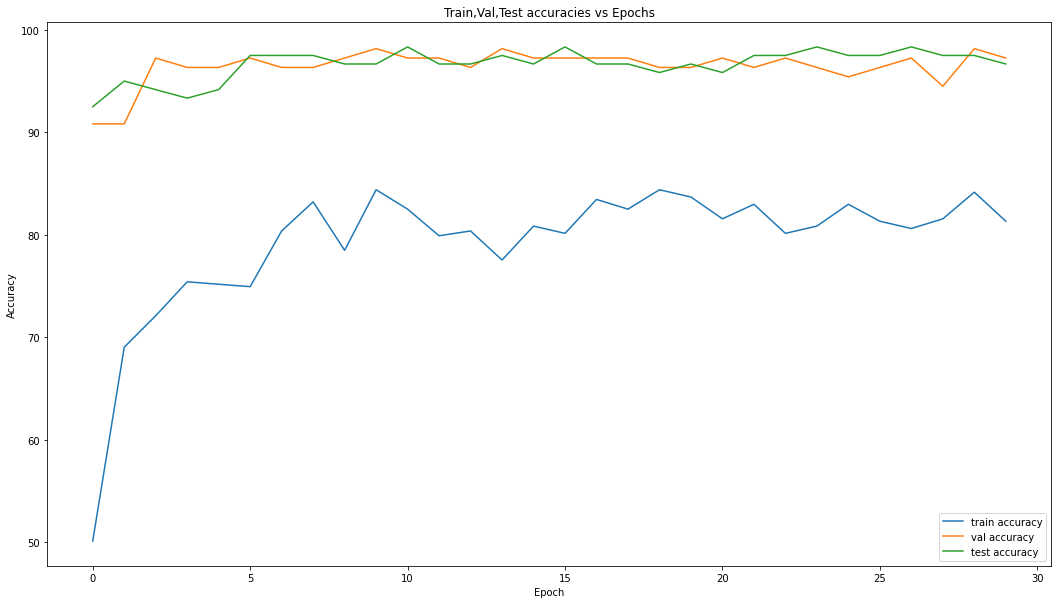

In [10]:
accuracies=torch.tensor(accuracies,device='cpu').numpy()
fig = plt.figure(figsize=(18,10))
for i in accuracies:
  plt.plot(i*100)
  plt.legend(['train accuracy','val accuracy','test accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Train,Val,Test accuracies vs Epochs")
  plt.savefig('accuracy-vs-epoch')

### **VISUALIZING THE MODEL**

In [16]:
def visualize_model(model, num_images=6):                   #visualize model
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    fig = plt.figure(figsize=(8,8))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

                inv_tensor = invTrans(inputs.cpu().data[j])
                plt.imshow(inv_tensor.permute(1,2,0))
                #imshow(inputs.cpu().data[j].permute(1,2,0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

<Figure size 432x288 with 0 Axes>

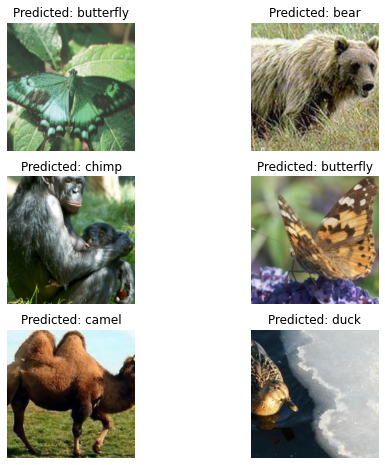

In [17]:
visualize_model(model_ft)    #some predicted images


### **CALCULATING TEST ACCURACY**

In [13]:
def test_model(dataloaders_test,model_ft):
  model_ft.eval()
  correct_count=0
  y_true=[]
  y_pred=[]
  images_so_far = 0
  fig = plt.figure(figsize=(15, 15))
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_test['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model_ft(inputs)
      _, preds = torch.max(outputs, 1)                         
      for j in range(inputs.size()[0]):
        images_so_far += 1
        y_true.append(class_names[labels[j]])
        y_pred.append(class_names[preds[j]])                               
        if(class_names[labels[j]]==class_names[preds[j]]):  #if predicted_label matches the original_label  
          correct_count+=1
    print("Test Accuracy: ")
    print((correct_count/images_so_far)*100)
    print("----------------------------")
    print("Classification Report:")
    report=metrics.classification_report(y_true, y_pred)
    print(report)
    print("----------------------------")
    print("Confusion Matrix:")
    cf_matrix=metrics.confusion_matrix(y_true, y_pred)
    print(cf_matrix)

In [14]:
test_model(dataloaders_test,model_ft)


Test Accuracy: 
96.66666666666667
----------------------------
Classification Report:
              precision    recall  f1-score   support

        bear       1.00      0.90      0.95        20
   butterfly       1.00      1.00      1.00        20
       camel       0.91      1.00      0.95        20
       chimp       0.95      0.95      0.95        20
        duck       1.00      1.00      1.00        20
    elephant       0.95      0.95      0.95        20

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

----------------------------
Confusion Matrix:
[[18  0  1  1  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 19  0  1]
 [ 0  0  0  0 20  0]
 [ 0  0  1  0  0 19]]


<Figure size 1080x1080 with 0 Axes>